In [36]:

import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 오토인코더 모델 클래스들 (paste.txt에서 가져온 것)
class ImprovedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=4):
        super(ImprovedAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim

        # Encoder: 12 ➔ 8 ➔ 4
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(8, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.ReLU()
        )

        # Decoder: 4 ➔ 8 ➔ 12
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(8, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=4):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder: 12 ➔ 8
        self.encoder_layers = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        # 평균과 분산
        self.fc_mu = nn.Linear(8, latent_dim)
        self.fc_logvar = nn.Linear(8, latent_dim)

        # Decoder: 4 ➔ 8 ➔ 12
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(8, input_dim)
        )

    def encode(self, x):
        h = self.encoder_layers(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar, z


class BetaVAE(VariationalAutoencoder):
    def __init__(self, input_dim, latent_dim=4, beta=1.0):
        super(BetaVAE, self).__init__(input_dim, latent_dim)
        self.beta = beta


class EnsembleAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=3, n_models=3):
        super(EnsembleAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.n_models = n_models
        
        # 다양한 구조의 오토인코더들
        self.autoencoders = nn.ModuleList()
        
        for i in range(n_models):
            # 각 모델마다 조금씩 다른 구조
            latent_dim = encoding_dim + i
            ae = ImprovedAutoencoder(input_dim, latent_dim)
            self.autoencoders.append(ae)
        
    def forward(self, x):
        outputs = []
        encodings = []
        
        for ae in self.autoencoders:
            decoded, encoded = ae(x)
            outputs.append(decoded)
            encodings.append(encoded)
            
        # 평균 출력
        avg_output = torch.mean(torch.stack(outputs), dim=0)
        return avg_output, encodings


def load_trained_model(model_path, scaler_path):
    """훈련된 모델 로드"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(model_path, map_location=device)
    
    input_dim = checkpoint['input_dim']
    encoding_dim = checkpoint['encoding_dim']
    model_type = checkpoint.get('model_type', 'improved')

    # 모델 타입에 따른 모델 생성
    if model_type == "improved":
        model = ImprovedAutoencoder(input_dim, encoding_dim).to(device)
    elif model_type == "vae":
        model = VariationalAutoencoder(input_dim, encoding_dim).to(device)
    elif model_type == "beta_vae":
        model = BetaVAE(input_dim, encoding_dim, beta=2.0).to(device)
    elif model_type == "ensemble":
        model = EnsembleAutoencoder(input_dim, encoding_dim, n_models=3).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.load_state_dict(checkpoint['model_state_dict'])
    scaler = joblib.load(scaler_path)

    # print(f"✅ 모델 로드 완료 - Type: {model_type}, Input dim: {input_dim}, Encoding dim: {encoding_dim}")
    # print(f"✅ 최고 검증 손실: {checkpoint['best_val_loss']:.6f}")
    return model, scaler


def detect_go_around_probability_statistical(model_path, test_data_path, scaler_path, normal_data_path, probability_method='one_tailed'):
    """Go-around 확률 통계적 분석"""
    # 모델과 스케일러 로드
    model, scaler = load_trained_model(model_path, scaler_path)
    
    # 테스트 데이터 로드
    test_df = pd.read_csv(test_data_path, encoding='utf-8-sig')
    test_df = test_df.apply(pd.to_numeric, errors='coerce').dropna()
    
    # 정상 데이터 로드 (베이스라인 계산용)
    normal_df = pd.read_csv(normal_data_path, encoding='utf-8-sig')
    normal_df = normal_df.apply(pd.to_numeric, errors='coerce').dropna()
    
    # 데이터 전처리
    test_scaled = scaler.transform(test_df)
    normal_scaled = scaler.transform(normal_df)
    
    # 텐서로 변환
    device = next(model.parameters()).device
    test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)
    normal_tensor = torch.tensor(normal_scaled, dtype=torch.float32).to(device)
    
    # 모델 평가 모드
    model.eval()
    
    with torch.no_grad():
        # 테스트 데이터 재구성 오차 계산
        if isinstance(model, (VariationalAutoencoder, BetaVAE)):
            test_reconstructed, mu, logvar, _ = model(test_tensor)
            test_recon_error = torch.mean((test_tensor - test_reconstructed) ** 2, dim=1)
        elif isinstance(model, EnsembleAutoencoder):
            test_reconstructed, _ = model(test_tensor)
            test_recon_error = torch.mean((test_tensor - test_reconstructed) ** 2, dim=1)
        else:
            test_reconstructed, _ = model(test_tensor)
            test_recon_error = torch.mean((test_tensor - test_reconstructed) ** 2, dim=1)
        
        # 정상 데이터 재구성 오차 계산 (베이스라인)
        if isinstance(model, (VariationalAutoencoder, BetaVAE)):
            normal_reconstructed, mu_normal, logvar_normal, _ = model(normal_tensor)
            normal_recon_error = torch.mean((normal_tensor - normal_reconstructed) ** 2, dim=1)
        elif isinstance(model, EnsembleAutoencoder):
            normal_reconstructed, _ = model(normal_tensor)
            normal_recon_error = torch.mean((normal_tensor - normal_reconstructed) ** 2, dim=1)
        else:
            normal_reconstructed, _ = model(normal_tensor)
            normal_recon_error = torch.mean((normal_tensor - normal_reconstructed) ** 2, dim=1)
    
    # CPU로 이동
    test_errors = test_recon_error.cpu().numpy()
    normal_errors = normal_recon_error.cpu().numpy()
    
    # 정상 데이터 통계량 계산
    normal_mean = np.mean(normal_errors)
    normal_std = np.std(normal_errors)
    
    # 각 테스트 샘플에 대한 분석
    results = []
    
    for i, test_error in enumerate(test_errors):
        # Z-score 계산
        z_score = (test_error - normal_mean) / normal_std if normal_std > 0 else 0
        
        # P-value 계산
        if probability_method == 'one_tailed':
            p_value = 1 - stats.norm.cdf(z_score)  # 오른쪽 꼬리 (높은 오차가 이상)
        else:
            p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))  # 양쪽 꼬리
        
        # Go-around 확률 (백분율)
        go_around_prob_percent = (1 - p_value) * 100
        
        # 리스크 레벨
        if p_value < 0.05:
            risk_level = "HIGH"
        elif p_value < 0.1:
            risk_level = "MEDIUM"
        else:
            risk_level = "LOW"
        
        results.append({
            'sample_index': i,
            'reconstruction_error': test_error,
            'z_score': z_score,
            'p_value': p_value,
            'go_around_probability_percent': go_around_prob_percent,
            'risk_level': risk_level
        })
    
    # 결과를 DataFrame으로 변환
    row_results = pd.DataFrame(results)
    
    # 원본 데이터와 결과 합치기
    df_original = test_df.copy()
    df_combined = pd.concat([df_original.reset_index(drop=True), row_results.reset_index(drop=True)], axis=1)
    
    return df_combined, row_results


In [ ]:

# # 메인 배치 처리 코드
# BASE_DIR = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs"
# test_data_path = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test).csv"
# normal_data_path = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\59개59개 빼고 남은거(학습용데이터)(로그변환).csv"

# experiment_dirs = [d for d in glob(os.path.join(BASE_DIR, "*")) if os.path.isdir(d)]
# print(f"🔍 총 {len(experiment_dirs)}개의 실험 폴더 감지. 반복 처리 시작.\n")

# combined_csv_path = os.path.join(BASE_DIR, "batch_go_around_summary_avg_RUNS2.csv")
# if os.path.exists(combined_csv_path):
#     os.remove(combined_csv_path)

# # 🩶 누적 결과를 담을 리스트 (모델별 요약 결과)
# summary_results_list = []

# for exp_dir in tqdm(experiment_dirs):
#     model_path = os.path.join(exp_dir, "best_autoencoder.pt")
#     scaler_path = os.path.join(exp_dir, "scaler.pkl")
#     output_dir = os.path.join(exp_dir, "go_around_analysis_statistical")
#     done_marker = os.path.join(output_dir, "done.marker")
    
#     if os.path.exists(done_marker):
#         os.remove(done_marker)
    
#     if not os.path.exists(model_path) or not os.path.exists(scaler_path):
#         print(f"⚠️ {exp_dir} → 모델 또는 스케일러가 없어 스킵.")
#         continue
    
#     try:
#         print(f"\n🚀 {exp_dir} 분석 시작...")
#         df_original, row_results = detect_go_around_probability_statistical(
#             model_path=model_path,
#             test_data_path=test_data_path,
#             scaler_path=scaler_path,
#             normal_data_path=normal_data_path,
#             probability_method='one_tailed'
#         )
        
#         # 모델(폴더) 이름
#         folder_name = os.path.basename(exp_dir)
        
#         # 59개 등 여러 행의 go_around_probability_percent 평균 구하기
#         avg_prob_percent = row_results['go_around_probability_percent'].mean()
#         avg_reconstruction_error = row_results['reconstruction_error'].mean()
#         avg_z_score = row_results['z_score'].mean()
#         avg_p_value = row_results['p_value'].mean()
        
#         # 리스크 레벨은 평균 확률 기준으로 새로 정하기 (임계값은 기존과 동일)
#         if avg_p_value < 0.05:
#             risk_level = "HIGH"
#         elif avg_p_value < 0.1:
#             risk_level = "MEDIUM"
#         else:
#             risk_level = "LOW"
        
#         # 모델별 요약 결과 DataFrame 생성
#         summary_row = pd.DataFrame({
#             'experiment_folder': [folder_name],
#             'avg_reconstruction_error': [avg_reconstruction_error],
#             'avg_z_score': [avg_z_score],
#             'avg_p_value': [avg_p_value],
#             'avg_go_around_probability_percent': [avg_prob_percent],
#             'risk_level': [risk_level]
#         })
        
#         summary_results_list.append(summary_row)
        
#         # 완료 마커 생성
#         os.makedirs(output_dir, exist_ok=True)
#         with open(done_marker, 'w') as f:
#             f.write("done")
        
#         print(f"✅ {exp_dir} 완료 및 요약 결과 누적.\n")
        
#     except Exception as e:
#         print(f"❌ {exp_dir} 처리 실패: {e}\n")

# # --------------------------
# # 모든 모델 요약 결과 합쳐서 CSV 저장
# if summary_results_list:
#     combined_summary_df = pd.concat(summary_results_list, ignore_index=True)
#     combined_summary_df.to_csv(combined_csv_path, index=False, encoding='utf-8-sig')
    
#     print(f"\n✅ 모델별 평균 요약 CSV 저장 완료: '{combined_csv_path}'")
#     print(combined_summary_df.head())
#     print(f"\n총 {len(combined_summary_df)} 개 모델 결과 저장 완료.")
# else:
#     print("\n⚠️ 저장할 요약 결과가 없습니다.")
# # --------------------------

# print(f"\n🎉 모든 반복 처리 완료 및 모델별 평균 요약 CSV 생성 완료.")

🔍 총 340개의 실험 폴더 감지. 반복 처리 시작.



  0%|          | 0/340 [00:00<?, ?it/s]

  1%|          | 4/340 [00:00<00:08, 38.81it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.0001_ep500_20250713-214108 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 128.148732
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.0001_ep500_20250713-214108 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.0002_ep500_20250713-214011 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 123.413642
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.0002_ep500_20250713-214011 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.0003_ep500_20250713-213936 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 122.171732
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\r

  4%|▍         | 13/340 [00:00<00:08, 37.35it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.001_ep500_20250713-213742 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.002_ep500_20250713-213720 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 118.256055
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.002_ep500_20250713-213720 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.003_ep500_20250713-213654 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 118.252574
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.003_ep500_20250713-213654 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr0.005_ep500_20250713-213640 분석 시작...
✅ 모델 로드 완료 - Type: beta_

  7%|▋         | 23/340 [00:00<00:07, 40.66it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr7e-05_ep500_20250713-214243 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr9e-05_ep500_20250713-214152 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 131.346130
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs16_lr9e-05_ep500_20250713-214152 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.0001_ep500_20250713-215202 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 256.651081
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.0001_ep500_20250713-215202 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.0002_ep500_20250713-215143 분석 시작...
✅ 모델 로드 완료 - Type: be

  8%|▊         | 28/340 [00:00<00:07, 41.42it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.002_ep500_20250713-214949 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.003_ep500_20250713-214935 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 233.762101
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.003_ep500_20250713-214935 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.005_ep500_20250713-214924 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 234.701317
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.005_ep500_20250713-214924 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr0.01_ep500_20250713-214913 분석 시작...
✅ 모델 로드 완료 - Type: beta_v

 11%|█         | 38/340 [00:00<00:07, 41.05it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr9e-05_ep500_20250713-215236 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 262.728104
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs32_lr9e-05_ep500_20250713-215236 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0001_ep500_20250713-205435 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 37.367478
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0001_ep500_20250713-205435 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0002_ep500_20250713-205238 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 33.527023
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\bet

 14%|█▍        | 48/340 [00:01<00:07, 40.69it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.002_ep500_20250713-204351 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.003_ep500_20250713-204318 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 34.720105
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.003_ep500_20250713-204318 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.005_ep500_20250713-204242 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 34.174085
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.005_ep500_20250713-204242 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.01_ep500_20250713-204208 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Inpu

 16%|█▌        | 53/340 [00:01<00:06, 41.43it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr9e-05_ep500_20250713-205717 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.0001_ep500_20250713-215832 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 549.171080
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.0001_ep500_20250713-215832 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.0002_ep500_20250713-215817 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 490.673006
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.0002_ep500_20250713-215817 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.0003_ep500_20250713-215803 분석 시작...
✅ 모델 로드 완료 - Type: b

 19%|█▊        | 63/340 [00:01<00:06, 42.39it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.002_ep500_20250713-215723 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 486.568241
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.002_ep500_20250713-215723 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.003_ep500_20250713-215709 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 465.408200
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.003_ep500_20250713-215709 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr0.005_ep500_20250713-215704 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 465.240164
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\b

 21%|██▏       | 73/340 [00:01<00:06, 41.70it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr7e-05_ep500_20250713-215903 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr9e-05_ep500_20250713-215844 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 518.086918
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs64_lr9e-05_ep500_20250713-215844 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.0001_ep500_20250713-212236 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 65.047630
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.0001_ep500_20250713-212236 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.0002_ep500_20250713-212131 분석 시작...
✅ 모델 로드 완료 - Type: beta_v

 24%|██▍       | 83/340 [00:02<00:05, 42.89it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.002_ep500_20250713-211719 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.003_ep500_20250713-211636 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 60.085340
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.003_ep500_20250713-211636 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.005_ep500_20250713-211532 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 60.247104
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.005_ep500_20250713-211532 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs8_lr0.01_ep500_20250713-211455 분석 시작...
✅ 모델 로드 완료 - Type: beta_vae, Inpu

 26%|██▌       | 88/340 [00:02<00:06, 40.97it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.043799
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.0001_ep500_20250713-231458 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.0002_ep500_20250713-231345 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.049315
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.0002_ep500_20250713-231345 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.0003_ep500_20250713-231243 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.040647
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.0003_ep500_20250713-231243 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\

 29%|██▊       | 97/340 [00:02<00:06, 35.30it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.042481
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.001_ep500_20250713-230949 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.002_ep500_20250713-230921 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.047160
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.002_ep500_20250713-230921 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.003_ep500_20250713-230854 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.044007
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr0.003_ep500_20250713-230854 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\

 30%|██▉       | 101/340 [00:02<00:07, 33.42it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr2e-05_ep500_20250713-232338 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr3e-05_ep500_20250713-232137 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.081993
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr3e-05_ep500_20250713-232137 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr5e-05_ep500_20250713-232000 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.076660
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr5e-05_ep500_20250713-232000 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs16_lr7e-05_ep500_20250713-231841 분석 시작...
✅ 모델 로드 완료 - Type: ensemble,

 32%|███▏      | 109/340 [00:02<00:07, 32.39it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.030072
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.0003_ep500_20250713-233128 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.0005_ep500_20250713-233055 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.032018
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.0005_ep500_20250713-233055 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.0007_ep500_20250713-233032 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.034282
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.0007_ep500_20250713-233032 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\

 33%|███▎      | 113/340 [00:02<00:07, 31.57it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.003_ep500_20250713-232917 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.005_ep500_20250713-232859 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.031350
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.005_ep500_20250713-232859 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.01_ep500_20250713-232840 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.031480
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr0.01_ep500_20250713-232840 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr1e-05_ep500_20250713-234011 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, I

 36%|███▌      | 121/340 [00:03<00:07, 30.80it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr5e-05_ep500_20250713-233614 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr7e-05_ep500_20250713-233500 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.057608
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr7e-05_ep500_20250713-233500 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr9e-05_ep500_20250713-233355 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.051367
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs32_lr9e-05_ep500_20250713-233355 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.0001_ep500_20250713-221705 분석 시작...
✅ 모델 로드 완료 - Type: ensemble,

 38%|███▊      | 129/340 [00:03<00:07, 29.78it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.0007_ep500_20250713-220840 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.0009_ep500_20250713-220720 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.184036
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.0009_ep500_20250713-220720 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.001_ep500_20250713-220613 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.175445
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.001_ep500_20250713-220613 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr0.002_ep500_20250713-220506 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, In

 39%|███▉      | 133/340 [00:03<00:06, 30.20it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.355580
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr1e-05_ep500_20250713-223635 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr2e-05_ep500_20250713-223116 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.244304
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr2e-05_ep500_20250713-223116 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr3e-05_ep500_20250713-222649 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.187580
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs4_lr3e-05_ep500_20250713-222649 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensem

 41%|████▏     | 141/340 [00:03<00:06, 29.20it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.050576
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.0001_ep500_20250713-234449 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.0002_ep500_20250713-234405 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.031887
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.0002_ep500_20250713-234405 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.0003_ep500_20250713-234333 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.033428
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.0003_ep500_20250713-234333 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\

 44%|████▎     | 148/340 [00:04<00:06, 29.43it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.030097
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.001_ep500_20250713-234204 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.002_ep500_20250713-234151 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.025898
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.002_ep500_20250713-234151 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.003_ep500_20250713-234142 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.025697
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr0.003_ep500_20250713-234142 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\

 45%|████▍     | 152/340 [00:04<00:06, 29.64it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr2e-05_ep500_20250713-234831 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr3e-05_ep500_20250713-234733 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.137555
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr3e-05_ep500_20250713-234733 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr5e-05_ep500_20250713-234652 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.067163
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr5e-05_ep500_20250713-234652 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs64_lr7e-05_ep500_20250713-234609 분석 시작...
✅ 모델 로드 완료 - Type: ensemble,

 46%|████▋     | 158/340 [00:04<00:06, 29.76it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.0003_ep500_20250713-224751 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.070926
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.0003_ep500_20250713-224751 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.0005_ep500_20250713-224635 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.072396
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.0005_ep500_20250713-224635 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.0007_ep500_20250713-224547 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.065820
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensembl

 49%|████▊     | 165/340 [00:04<00:06, 28.47it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.002_ep500_20250713-224237 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.003_ep500_20250713-224151 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.080429
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.003_ep500_20250713-224151 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.005_ep500_20250713-224117 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.093242
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.005_ep500_20250713-224117 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr0.01_ep500_20250713-224044 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input 

 50%|█████     | 171/340 [00:04<00:05, 28.24it/s]

✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.127813
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr3e-05_ep500_20250713-225918 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr5e-05_ep500_20250713-225541 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.095727
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr5e-05_ep500_20250713-225541 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr7e-05_ep500_20250713-225346 분석 시작...
✅ 모델 로드 완료 - Type: ensemble, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.088191
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensemble_bs8_lr7e-05_ep500_20250713-225346 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\ensem

 52%|█████▏    | 176/340 [00:05<00:05, 32.01it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0003_ep500_20250713-190351 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0005_ep500_20250713-190313 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.127208
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0005_ep500_20250713-190313 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0007_ep500_20250713-190241 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.132905
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0007_ep500_20250713-190241 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr0.0009_ep500_20250713-190218 분석 시작...
✅ 모델 로드 완료 - Type: imp

 55%|█████▌    | 187/340 [00:05<00:03, 40.05it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr1e-05_ep500_20250713-191004 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.488911
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr1e-05_ep500_20250713-191004 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr2e-05_ep500_20250713-190856 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.228439
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr2e-05_ep500_20250713-190856 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs16_lr3e-05_ep500_20250713-190754 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.223706
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improve

 58%|█████▊    | 197/340 [00:05<00:03, 42.02it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.0005_ep500_20250713-191240 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.0007_ep500_20250713-191225 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.134653
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.0007_ep500_20250713-191225 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.0009_ep500_20250713-191206 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.121174
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.0009_ep500_20250713-191206 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr0.001_ep500_20250713-191147 분석 시작...
✅ 모델 로드 완료 - Type: impr

 61%|██████    | 207/340 [00:05<00:03, 42.87it/s]

✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.222901
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr5e-05_ep500_20250713-191540 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr7e-05_ep500_20250713-191503 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.223687
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr7e-05_ep500_20250713-191503 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr9e-05_ep500_20250713-191436 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.187238
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs32_lr9e-05_ep500_20250713-191436 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\

 64%|██████▍   | 217/340 [00:06<00:02, 43.70it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.0009_ep500_20250713-181857 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.001_ep500_20250713-181825 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.337865
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.001_ep500_20250713-181825 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.002_ep500_20250713-181744 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.366692
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.002_ep500_20250713-181744 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr0.003_ep500_20250713-181716 분석 시작...
✅ 모델 로드 완료 - Type: improved, Inpu

 67%|██████▋   | 227/340 [00:06<00:02, 45.09it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr7e-05_ep500_20250713-182718 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr9e-05_ep500_20250713-182617 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.279085
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs4_lr9e-05_ep500_20250713-182617 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.0001_ep500_20250713-192030 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.188921
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.0001_ep500_20250713-192030 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.0002_ep500_20250713-192010 분석 시작...
✅ 모델 로드 완료 - Type: improved,

 70%|██████▉   | 237/340 [00:06<00:02, 46.06it/s]

✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.113505
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.003_ep500_20250713-191843 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.005_ep500_20250713-191829 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.091037
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.005_ep500_20250713-191829 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.01_ep500_20250713-191823 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.098381
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs64_lr0.01_ep500_20250713-191823 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\im

 71%|███████   | 242/340 [00:06<00:02, 44.54it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0001_ep500_20250713-185120 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0002_ep500_20250713-185022 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.193612
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0002_ep500_20250713-185022 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0003_ep500_20250713-184955 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.190661
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0003_ep500_20250713-184955 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.0005_ep500_20250713-184856 분석 시작...
✅ 모델 로드 완료 - Type: improved,

 74%|███████▍  | 252/340 [00:06<00:01, 44.76it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.005_ep500_20250713-184509 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.206504
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.005_ep500_20250713-184509 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.01_ep500_20250713-184445 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.195530
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr0.01_ep500_20250713-184445 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_lr1e-05_ep500_20250713-185832 분석 시작...
✅ 모델 로드 완료 - Type: improved, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 0.337528
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\improved_bs8_l

 77%|███████▋  | 262/340 [00:07<00:01, 43.71it/s]

✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 93.307165
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0002_ep500_20250713-202149 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0003_ep500_20250713-202118 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 96.409006
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0003_ep500_20250713-202118 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0005_ep500_20250713-202047 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 89.143872
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0005_ep500_20250713-202047 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.0007_ep500_20250713

 80%|████████  | 273/340 [00:07<00:01, 46.00it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr0.01_ep500_20250713-201743 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr1e-05_ep500_20250713-202747 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 124.583480
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr1e-05_ep500_20250713-202747 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr2e-05_ep500_20250713-202638 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 111.725479
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr2e-05_ep500_20250713-202638 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs16_lr3e-05_ep500_20250713-202522 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실

 83%|████████▎ | 283/340 [00:07<00:01, 44.65it/s]

✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 174.459694
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.0007_ep500_20250713-203051 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.0009_ep500_20250713-203037 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 180.874203
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.0009_ep500_20250713-203037 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.001_ep500_20250713-203019 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 174.585155
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.001_ep500_20250713-203019 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr0.002_ep500_20250713

 86%|████████▌ | 293/340 [00:07<00:01, 45.77it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr3e-05_ep500_20250713-203447 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr5e-05_ep500_20250713-203404 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 210.865231
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr5e-05_ep500_20250713-203404 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr7e-05_ep500_20250713-203333 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 210.548693
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr7e-05_ep500_20250713-203333 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs32_lr9e-05_ep500_20250713-203255 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손

 89%|████████▉ | 304/340 [00:07<00:00, 46.55it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.001_ep500_20250713-192654 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.002_ep500_20250713-192600 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 26.475518
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.002_ep500_20250713-192600 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.003_ep500_20250713-192520 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 27.755643
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.003_ep500_20250713-192520 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr0.005_ep500_20250713-192441 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 27.63

 92%|█████████▏| 314/340 [00:08<00:00, 46.37it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs4_lr9e-05_ep500_20250713-193638 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.0001_ep500_20250713-203911 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 430.212799
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.0001_ep500_20250713-203911 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.0002_ep500_20250713-203853 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 406.199904
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.0002_ep500_20250713-203853 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.0003_ep500_20250713-203839 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 

 94%|█████████▍| 319/340 [00:08<00:00, 47.32it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.003_ep500_20250713-203733 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 353.599699
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.003_ep500_20250713-203733 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.005_ep500_20250713-203722 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 346.677289
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.005_ep500_20250713-203722 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.01_ep500_20250713-203713 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 342.537838
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs64_lr0.01_ep500_20250713-203713 완료 및

 97%|█████████▋| 330/340 [00:08<00:00, 45.46it/s]

✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0002_ep500_20250713-200404 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0003_ep500_20250713-200319 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 48.400674
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0003_ep500_20250713-200319 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0005_ep500_20250713-200217 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 47.353447
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0005_ep500_20250713-200217 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr0.0007_ep500_20250713-200142 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실:

100%|██████████| 340/340 [00:08<00:00, 39.10it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr1e-05_ep500_20250713-201537 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 89.443417
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr1e-05_ep500_20250713-201537 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr2e-05_ep500_20250713-201316 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 63.989578
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr2e-05_ep500_20250713-201316 완료 및 요약 결과 누적.


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr3e-05_ep500_20250713-201128 분석 시작...
✅ 모델 로드 완료 - Type: vae, Input dim: 12, Encoding dim: 4
✅ 최고 검증 손실: 53.126992
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\vae_bs8_lr3e-05_ep500_20250713-201128 완료 및 요약 결과 

In [ ]:
# 단일 모델 Go-Around 확률 분석 코드
import os
import pandas as pd
from tqdm import tqdm

def analyze_single_model_go_around(model_path, scaler_path, test_data_path, normal_data_path, output_dir=None):

    
    # 파일 존재 여부 확인
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"모델 파일을 찾을 수 없습니다: {model_path}")
    if not os.path.exists(scaler_path):
        raise FileNotFoundError(f"스케일러 파일을 찾을 수 없습니다: {scaler_path}")
    if not os.path.exists(test_data_path):
        raise FileNotFoundError(f"테스트 데이터 파일을 찾을 수 없습니다: {test_data_path}")
    if not os.path.exists(normal_data_path):
        raise FileNotFoundError(f"정상 데이터 파일을 찾을 수 없습니다: {normal_data_path}")
    
    # 출력 디렉토리 설정
    if output_dir is None:
        output_dir = os.path.dirname(model_path)
    
    # 분석 결과 저장할 디렉토리 생성
    analysis_output_dir = os.path.join(output_dir, "go_around_analysis_statistical")
    os.makedirs(analysis_output_dir, exist_ok=True)

    
    try:
        # Go-Around 확률 탐지 실행
        df_original, row_results = detect_go_around_probability_statistical(
            model_path=model_path,
            test_data_path=test_data_path,
            scaler_path=scaler_path,
            normal_data_path=normal_data_path,
            probability_method='one_tailed'
        )
        
        # 모델명 (파일명에서 확장자 제거)
        model_name = os.path.splitext(os.path.basename(model_path))[0]
        
        # 개별 행 결과 CSV 저장
        detailed_csv_path = os.path.join(analysis_output_dir, f"{model_name}_detailed_results.csv")
        row_results.to_csv(detailed_csv_path, index=False, encoding='utf-8-sig')
        
        # 평균 통계 계산
        avg_prob_percent = row_results['go_around_probability_percent'].mean()
        avg_reconstruction_error = row_results['reconstruction_error'].mean()
        avg_z_score = row_results['z_score'].mean()
        avg_p_value = row_results['p_value'].mean()
        
        # 리스크 레벨 결정
        if avg_p_value < 0.05:
            risk_level = "HIGH"
        elif avg_p_value < 0.1:
            risk_level = "MEDIUM"
        else:
            risk_level = "LOW"
        
        # 요약 결과 생성
        summary_result = {
            'model_name': model_name,
            'model_path': model_path,
            'total_test_samples': len(row_results),
            'avg_reconstruction_error': avg_reconstruction_error,
            'avg_z_score': avg_z_score,
            'avg_p_value': avg_p_value,
            'avg_go_around_probability_percent': avg_prob_percent,
            'risk_level': risk_level,
            'high_risk_samples': len(row_results[row_results['p_value'] < 0.05]),
            'medium_risk_samples': len(row_results[(row_results['p_value'] >= 0.05) & (row_results['p_value'] < 0.1)]),
            'low_risk_samples': len(row_results[row_results['p_value'] >= 0.1])
        }
        
        # 요약 결과 DataFrame 생성 및 CSV 저장
        summary_df = pd.DataFrame([summary_result])
        summary_csv_path = os.path.join(analysis_output_dir, f"{model_name}_summary.csv")
        summary_df.to_csv(summary_csv_path, index=False, encoding='utf-8-sig')
        
        # 결과 출력

        
        print(avg_prob_percent)
        # 완료 마커 생성
        done_marker = os.path.join(analysis_output_dir, "done.marker")
        with open(done_marker, 'w') as f:
            f.write("analysis_completed")
        
        return row_results, summary_result
        
    except Exception as e:
        print(f"❌ 분석 실패: {e}")
        raise


# 사용 예시
if __name__ == "__main__":
    # 경로 설정
    MODEL_PATH = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0001_ep500_20250713-205435\best_autoencoder.pt"
    SCALER_PATH = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0001_ep500_20250713-205435\scaler.pkl"
    TEST_DATA_PATH = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test).csv"
    NORMAL_DATA_PATH = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\59개59개 빼고 남은거(학습용데이터)(로그변환).csv"
    
    # 단일 모델 분석 실행
    try:
        detailed_results, summary = analyze_single_model_go_around(
            model_path=MODEL_PATH,
            scaler_path=SCALER_PATH,
            test_data_path=TEST_DATA_PATH,
            normal_data_path=NORMAL_DATA_PATH
        )
        
        
    except Exception as e:
        print(f"❌ 오류 발생: {e}")

52.297162694086275
📊 확률 그래프 저장: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\newmodel\runs2\runs\beta_vae_bs4_lr0.0001_ep500_20250713-205435\go_around_analysis_statistical\best_autoencoder_probability_simple.png
🔍 총 127개의 실험 폴더 감지. 반복 처리 시작.



100%|██████████| 127/127 [00:00<00:00, 2640.08it/s]

⚠️ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\batch_probability_results → 모델 또는 스케일러가 없어 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0001_ep500_20250709-205535 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0002_ep500_20250709-205516 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0003_ep500_20250709-205502 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0005_ep500_20250709-205448 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0007_ep500_20250709-205435 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs\medium_ae_bs128_lr0.0009_ep500_20250709-205420 → 이미 완료된 작업, 스킵.
✅ C:\Users\USER\Deskto

🔍 총 126개의 실험 폴더 감지. 반복 처리 시작.



  0%|          | 0/126 [00:00<?, ?it/s]


🚀 C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\24_5layer\runs\runs\medium_ae_bs128_lr0.0001_ep500_20250709-233820 분석 시작...
🔍 통계적 방법을 사용한 고어라운드 확률 탐지
📊 정상 데이터 통계 새로 계산: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\59개59개 빼고 남은거(학습용데이터)(로그변환).csv
📊 정상 데이터 분포 통계 계산 중...
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.169198
   • 표준편차: 0.333050
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.483579, 0.821976]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.169198
   • 표준편차: 0.333050
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.158858
   • 평균 Z-score: -0.031047
   • 평균 P-value: 0.512384

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error   z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.158858 -0.031047               0.512384                      48.761593        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.158858     -0.031   0.512384     48.8     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.167677
   • 표준편차: 0.328891
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.476949, 0.812303]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.167677
   • 표준편차: 0.328891
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.154287
   • 평균 Z-score: -0.040712
   • 평균 P-value: 0.516237

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error   z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.154287 -0.040712               0.516237                      48.376267        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.154287     -0.041   0.516237     48.4     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.115461
   • 표준편차: 0.298923
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.470427, 0.701350]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.115461
   • 표준편차: 0.298923
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.154768
   • 평균 Z-score: 0.131494
   • 평균 P-value: 0.447692

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error  z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.154768 0.131494               0.447692                      55.230767        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.154768     0.131    0.447692     55.2     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs128

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.109967
   • 표준편차: 0.311876
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.501310, 0.721243]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.109967
   • 표준편차: 0.311876
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.083922
   • 평균 Z-score: -0.083511
   • 평균 P-value: 0.533278

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error   z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.083922 -0.083511               0.533278                      46.672247        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.083922     -0.084   0.533278     46.7     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.119857
   • 표준편차: 0.303285
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.474582, 0.714296]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.119857
   • 표준편차: 0.303285
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.139188
   • 평균 Z-score: 0.063741
   • 평균 P-value: 0.474588

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error  z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.139188 0.063741               0.474588                      52.541159        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.139188     0.064    0.474588     52.5     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs128

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.107723
   • 표준편차: 0.262304
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.406393, 0.621839]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.107723
   • 표준편차: 0.262304
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.142009
   • 평균 Z-score: 0.130713
   • 평균 P-value: 0.448001

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error  z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.142009 0.130713               0.448001                      55.199885        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.142009     0.131    0.448001     55.2     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                                experiment_folder  row_index  \
0  medium_ae_bs128

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

✅ 정상 데이터 통계 계산 완료:
   • 평균: 0.115387
   • 표준편차: 0.298196
   • 샘플 수: 5749
   • 95% 신뢰구간: [-0.469077, 0.699852]
📂 테스트 데이터 로드: C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv
📊 Original data shape: (1, 12)
📊 데이터는 이미 로그 변환되어 있습니다.
📊 Numeric columns selected: 12
📊 Missing values filled with mean
✅ Preprocessing complete - Final shape: (1, 12)
✅ 새로운 형식 모델 로드 완료 - Input: 12, Encoding: 6
🔍 테스트 데이터 reconstruction error 계산 중...
📊 통계적 확률 계산 중...


C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:460: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing fr


📊 통계적 분석 결과:
정상 데이터 통계:
   • 평균: 0.115387
   • 표준편차: 0.298196
   • 샘플 수: 5749

테스트 데이터 통계:
   • 평균 Error: 0.113025
   • 평균 Z-score: -0.007923
   • 평균 P-value: 0.503161

위험도 분류:
   • HIGH (p < 0.05): 0개
   • MEDIUM (0.05 ≤ p < 0.1): 0개
   • LOW (p ≥ 0.1): 1개

🔥 상위 10개 고위험 샘플:
 row_index  reconstruction_error   z_score  go_around_probability  go_around_probability_percent risk_level
         0              0.113025 -0.007923               0.503161                      49.683927        LOW

📋 각 행별 고어라운드 확률 분석:
행번호    Error        Z-score  P-value      확률(%)    위험도        해석
----------------------------------------------------------------------------------------------------
1      0.113025     -0.008   0.503161     49.7     LOW        정상 범위
✅ 행별 분석 완료!
📊 P-value가 낮을수록 고어라운드 가능성이 높습니다.
📊 확률(%)은 해당 행이 이상치일 확률을 나타냅니다.
📊 일반적으로 p < 0.05면 통계적으로 유의한 이상치로 간주됩니다.
📊 결과는 'row_by_row_probability_analysis.csv' 파일에 저장되었습니다.
                               experiment_folder  row_index  \
0  medium_ae_bs1

C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_21968\2217651818.py:254: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing fro

KeyboardInterrupt: 

c:\Users\USER\Desktop\FLIGHT_DATA\workspace\tf-env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\USER\Desktop\FLIGHT_DATA\workspace\tf-env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\USER\Desktop\FLIGHT_DATA\workspace\tf-env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\USER\Desktop\FLIGHT_DATA\workspace\tf-env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
c:\Users\USER\Desktop\FLIGHT_DATA\workspace\tf-env\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.

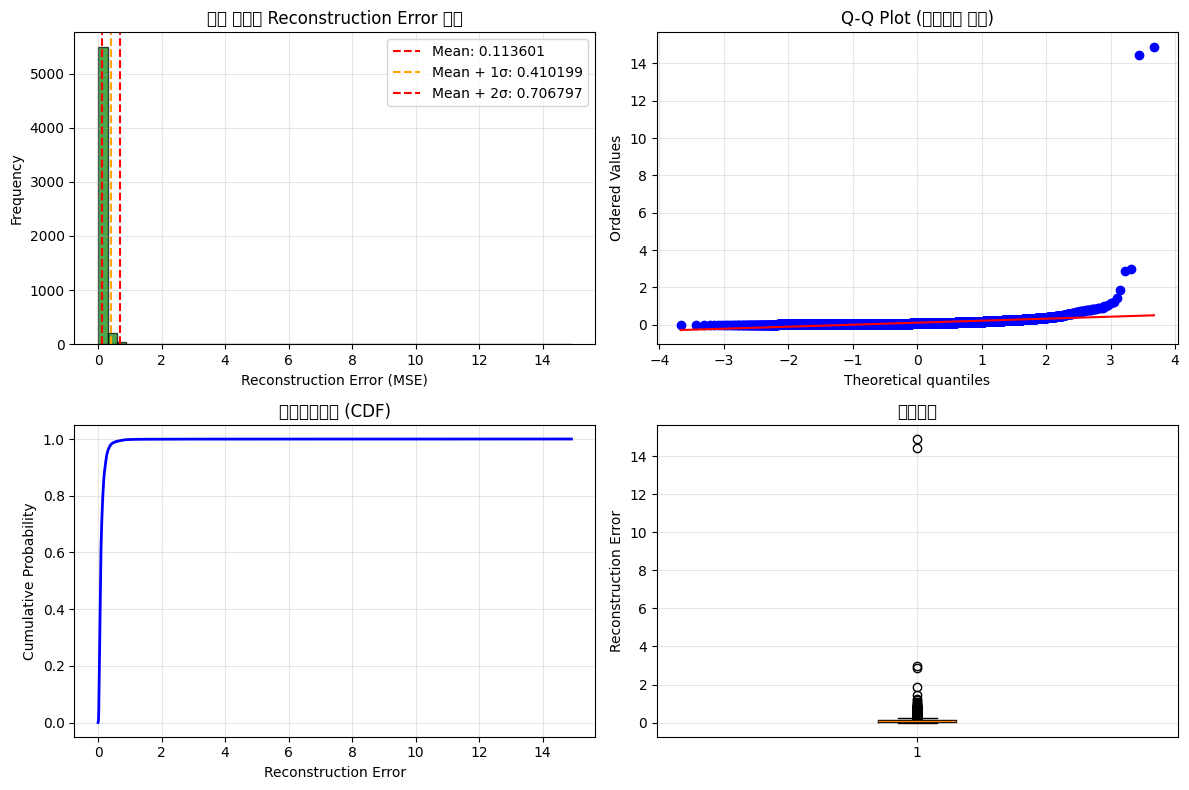

In [ ]:
import os
from glob import glob
from tqdm import tqdm

# 기존 작성하신 함수 임포트

# === 사용자 입력 ===
BASE_DIR = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\12_5layer\runs\runs"
test_data_path = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\고어라운드_된_날씨_합친_59개_로그변환(test)-1개.csv"
normal_data_path = r"C:\Users\USER\Desktop\FLIGHT_DATA\workspace\autoencoder\59개59개 빼고 남은거(학습용데이터)(로그변환).csv"

# === 반복 처리 ===
experiment_dirs = [d for d in glob(os.path.join(BASE_DIR, "*")) if os.path.isdir(d)]

print(f"🔍 총 {len(experiment_dirs)}개의 실험 폴더 감지. 반복 처리 시작.\n")

for exp_dir in tqdm(experiment_dirs):
    model_path = os.path.join(exp_dir, "best_autoencoder.pt")
    scaler_path = os.path.join(exp_dir, "scaler.pkl")
    output_dir = os.path.join(exp_dir, "go_around_analysis_statistical")
    done_marker = os.path.join(output_dir, "done.marker")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"⚠️ {exp_dir} → 모델 또는 스케일러가 없어 스킵.")
        continue

    if os.path.exists(done_marker):
        print(f"✅ {exp_dir} → 이미 완료된 작업, 스킵.")
        continue

    try:
        print(f"\n🚀 {exp_dir} 분석 시작...")
        detect_go_around_probability_statistical(
            model_path=model_path,
            test_data_path=test_data_path,
            scaler_path=scaler_path,
            normal_data_path=normal_data_path,
            probability_method='one_tailed'
        )
        # 완료 마커 생성
        os.makedirs(output_dir, exist_ok=True)
        with open(done_marker, 'w') as f:
            f.write("done")
        print(f"✅ {exp_dir} 완료.\n")
    except Exception as e:
        print(f"❌ {exp_dir} 처리 실패: {e}\n")

print("\n🎉 전체 반복 처리가 완료되었습니다.")
